# Airfoil experiments
All data is available in the repository

In [1]:
import sys
sys.path.append('../python')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from machine_learning import *
from notebook_network_size import find_best_network_size_notebook, try_best_network_sizes
from train_single_network import train_single_network
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


# Setup

In [2]:
qmc_points = np.loadtxt('../sobol_6_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,6))

large_qmc_points = np.loadtxt('../sobol_6_131072.txt')
all_points = qmc_points.copy()
forces = np.array(np.loadtxt('../force_6_params.dat'))


N = min(qmc_points.shape[0], forces.shape[0])
qmc_points = qmc_points[:N,:]
forces  = forces[:N,:]


input_size=6
train_size=128
validation_size=128

epochs = 500000

airfoils_network = [12, 12, 10, 12, 10, 12, 10, 10, 12,1]


# Network sizes

Find the optimal network size


Config 4 x 6 ([0 x 0] / [4 x 4])
Training and postprocessing took: 12.81951904296875 seconds (0.21365865071614584 minutes) (0.003560977511935764 hours)
Config 4 x 12 ([0 x 1] / [4 x 4])
Training and postprocessing took: 13.820601224899292 seconds (0.23034335374832154 minutes) (0.003839055895805359 hours)
Config 4 x 24 ([0 x 2] / [4 x 4])
Training and postprocessing took: 18.674794912338257 seconds (0.3112465818723043 minutes) (0.005187443031205071 hours)
Config 4 x 48 ([0 x 3] / [4 x 4])
Training and postprocessing took: 19.105716705322266 seconds (0.31842861175537107 minutes) (0.005307143529256184 hours)
Config 8 x 6 ([1 x 0] / [4 x 4])
Training and postprocessing took: 31.03843879699707 seconds (0.5173073132832845 minutes) (0.008621788554721408 hours)
Config 8 x 12 ([1 x 1] / [4 x 4])
Training and postprocessing took: 41.57850503921509 seconds (0.6929750839869181 minutes) (0.011549584733115301 hours)
Config 8 x 24 ([1 x 2] / [4 x 4])
Training and postprocessing took: 52.1970696449279

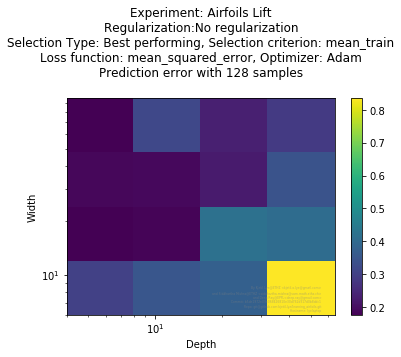

Memory usage: 3325336
all_errors_map[Error mean]=[[0.00096747 0.00096747 0.00096747 0.00096747]
 [0.00096747 0.00096747 0.00096747 0.00096747]
 [0.00096747 0.00096747 0.00096747 0.00096747]
 [0.00096747 0.00096747 0.00096747 0.00096747]]


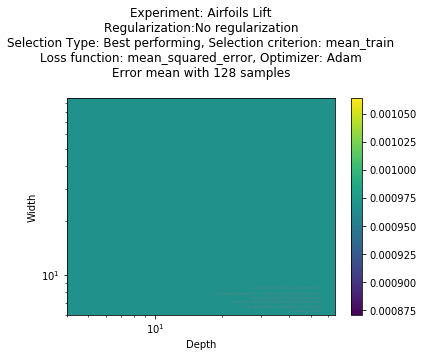

Memory usage: 3329904
all_errors_map[Error variance]=[[0.00883128 0.00883128 0.00883128 0.00883128]
 [0.00883128 0.00883128 0.00883128 0.00883128]
 [0.00883128 0.00883128 0.00883128 0.00883128]
 [0.00883128 0.00883128 0.00883128 0.00883128]]


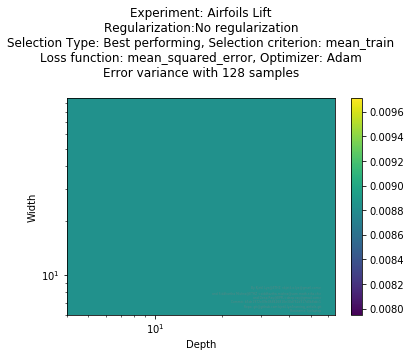

Memory usage: 3329904
all_errors_map[Wasserstein]=[[0.09939159 0.04425538 0.05482661 0.0672036 ]
 [0.1785205  0.09194973 0.08713977 0.18494662]
 [0.18823082 0.25899383 0.1206627  0.14172873]
 [0.58751084 0.24977977 0.21353949 0.17840061]]


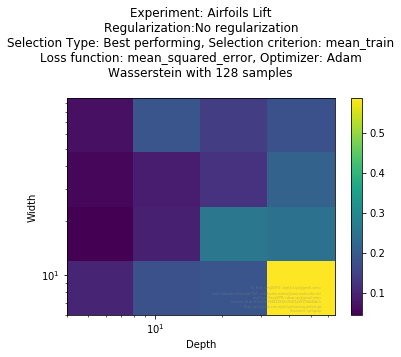

Memory usage: 3329904
all_errors_map[Selection error (mean_train)]=[[11.69990093  0.91165353  4.95392159  9.21120632]
 [21.30175837  7.80309908  8.15861745 21.55507516]
 [24.44964553 31.5912722   4.65308413  2.02861244]
 [73.03168251 29.02542656 25.97314403 17.37633309]]


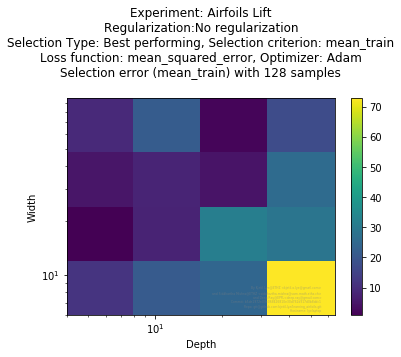

Memory usage: 3329904


Config 4 x 6 ([0 x 0] / [4 x 4])
Training and postprocessing took: 727.265563249588 seconds (12.121092720826466 minutes) (0.20201821201377443 hours)
Config 4 x 12 ([0 x 1] / [4 x 4])
Training and postprocessing took: 714.2158243656158 seconds (11.903597072760265 minutes) (0.1983932845460044 hours)
Config 4 x 24 ([0 x 2] / [4 x 4])
Training and postprocessing took: 872.7769873142242 seconds (14.546283121903738 minutes) (0.24243805203172897 hours)
Config 4 x 48 ([0 x 3] / [4 x 4])
Training and postprocessing took: 694.2369205951691 seconds (11.570615343252818 minutes) (0.19284358905421364 hours)
Config 8 x 6 ([1 x 0] / [4 x 4])
Training and postprocessing took: 863.916613817215 seconds (14.398610230286916 minutes) (0.2399768371714486 hours)
Config 8 x 12 ([1 x 1] / [4 x 4])
Training and postprocessing took: 948.3942818641663 seconds (15.806571364402771 minutes) (0.2634428560733795 hours)
Config 8 x 24 ([1 x 2] / [4 x 4])
Training and postprocessing took: 755.5559139251709 seconds (12.592

In [ ]:
force_names=['Lift', 'Drag']

for n, force_name in enumerate(force_names):
    display(HTML("<h1>%s</h1>"% force_name))
    try_best_network_sizes(parameters=qmc_points, 
                           samples=forces[:,n+1], 
                           base_title='Airfoils %s' % force_name,
                          epochs=epochs)

# One network per variable

In [ ]:
force_names=['Lift', 'Drag']

for n, force_name in enumerate(force_names):
    display(HTML("<h1>%s</h1>"% force_name))
    train_single_network(parameters=qmc_points, 
                         samples=forces[:,n+1], 
                         base_title='Airfoils %s' % force_name,
                         network = airfoils_network,
                         epochs=epochs, 
                         large_integration_points = None)

In [ ]:
x=keras.regularizers.l2(0.01)
print(x.l1)